<a href="https://colab.research.google.com/github/ganeshmukhiya/Topic-Modeling-NMF/blob/main/MODEL_ANALYSISI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


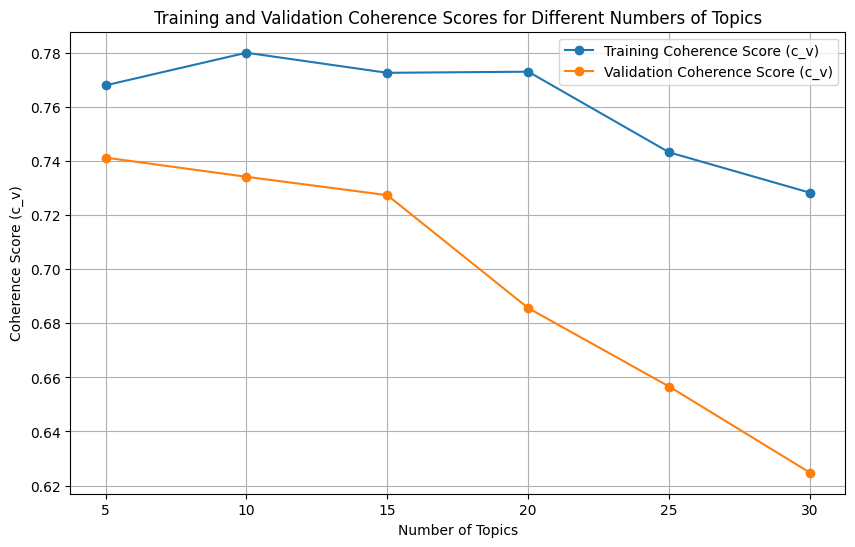

In [1]:

import nltk
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import numpy as np
import re
from nltk.tokenize import word_tokenize


# Download necessary NLTK data
nltk.download('punkt')


# Fetching and splitting the dataset
data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes')).data
train_data, val_data = np.split(data, [int(.8 * len(data))])

# Tokenizing the data for Gensim
def preprocess(text):
    return [word for word in word_tokenize(re.sub(r'\W+', ' ', text.lower())) if len(word) > 1]

tokenized_train_data = [preprocess(doc) for doc in train_data]
tokenized_val_data = [preprocess(doc) for doc in val_data]

# Vectorizing the training data
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
train_tfidf = vectorizer.fit_transform(train_data)

# Prepare Gensim Dictionary
dictionary = Dictionary(tokenized_train_data)

# Range of topics to test
topic_nums = range(5, 31, 5)
train_coherence_scores = []
val_coherence_scores = []

for num_topics in topic_nums:
    # Train the NMF model with the current number of topics
    nmf_model = NMF(n_components=num_topics, random_state=42)
    W_train = nmf_model.fit_transform(train_tfidf)
    H_train = nmf_model.components_

    # Prepare topics for coherence computation
    terms = vectorizer.get_feature_names_out()
    topics = [[terms[i] for i in topic.argsort()[:-11:-1]] for topic in H_train]

    # Compute training coherence score
    corpus_train = [dictionary.doc2bow(text) for text in tokenized_train_data]
    coherence_model_train = CoherenceModel(topics=topics, texts=tokenized_train_data, dictionary=dictionary, coherence='c_v')
    train_coherence_scores.append(coherence_model_train.get_coherence())

    # Compute validation coherence score
    corpus_val = [dictionary.doc2bow(text) for text in tokenized_val_data]
    coherence_model_val = CoherenceModel(topics=topics, texts=tokenized_val_data, dictionary=dictionary, coherence='c_v')
    val_coherence_scores.append(coherence_model_val.get_coherence())

# Plotting the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_nums, train_coherence_scores, marker='o', label='Training Coherence Score (c_v)')
plt.plot(topic_nums, val_coherence_scores, marker='o', label='Validation Coherence Score (c_v)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.title('Training and Validation Coherence Scores for Different Numbers of Topics')
plt.legend()
plt.grid(True)
plt.show()
